In [17]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline


Загружаем файл с именами

In [18]:
with open('data/names.txt') as names_f:
    words = names_f.read().splitlines()
    '''
    Как работает .splitlines()

    Он ищет любые символы переноса строки, включая:
        •	\n — Unix-перенос строки
        •	\r\n — Windows-перенос строки
        •	\r — старый Mac-перенос строки
        •	а также редкие юникодные разделители строк (например \u2028)
    '''

In [19]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [20]:
len(words)

32033

Самое короткое имя

In [21]:
min(len(w) for w in words)

2

Самое длинное имя

In [22]:
max(len(w) for w in words)

15

In [23]:
print([w for w in words if len(w) == 15])

['muhammadibrahim', 'muhammadmustafa']


# PART 1, делаем Bigram model

### Начинаем подготовку датасета

Разбиваем слова на подряд идущие символы

In [24]:
for w in words[:1]:
    for ch1, ch2 in zip(w, w[1:]):
        print(ch1, ch2)

e m
m m
m a


Добавляю специальные символы начала и конца слова, чтобы достать эту статистику тоже

In [25]:
for w in words[:3]:
    chs = ['<S>'] + list(w)  + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        print(ch1, ch2)

<S> e
e m
m m
m a
a <E>
<S> o
o l
l i
i v
v i
i a
a <E>
<S> a
a v
v a
a <E>


In [26]:
# print(w)
# print(list(w))
# print(['<S>'] + list(w)  + ['<E>'])

Добавляем счетчик как часто символы появляются друг за другом

In [27]:
b = {}

for w in words:
    chs = ['<S>'] + list(w)  + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

        '''
        b[bigram] = b.get(bigram, 0) + 1
        Возьми значение b для этого bigram, если нет, создай его и присвой значение 0
        И прибавь к этому значению 1
        '''

Вспоминаю get

In [28]:
# test_dict = {
#     'b' : 1,
#     'c': 2
# }
# test_dict

In [29]:
# test_dict['a'] = test_dict.get('a', 0)
# test_dict

Смотрим на самые часто встречающиеся сочетания

In [30]:
# b.items()

In [31]:
sorted(b.items())[:5]

[(('<S>', 'a'), 4410),
 (('<S>', 'b'), 1306),
 (('<S>', 'c'), 1542),
 (('<S>', 'd'), 1690),
 (('<S>', 'e'), 1531)]

kv = (ключ, значение)

kv[0] — ключ

kv[1] — значение

Сортировка по ключу

In [32]:
# sorted(b.items(), key=lambda kv: kv[0])

Сортировка по значению

In [33]:
# sorted(b.items(), key=lambda kv: kv[1])

Сортировка по значению в убывающем порядке

In [34]:
sorted(b.items(), key=lambda kv: -kv[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

Сохраняем результаты в 2D матрицу

In [35]:
a = torch.zeros(3, 5)
a

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [36]:
a.dtype

torch.float32

In [37]:
a = torch.zeros(3, 5, dtype=torch.int32)
a

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

In [38]:
a.dtype

torch.int32

In [39]:
a[1, 3] += 1
a

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

In [40]:
a[1, 3] += 1
a

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 2, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

In [41]:
a[0, 0] = 5
a

tensor([[5, 0, 0, 0, 0],
        [0, 0, 0, 2, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

Тензор для хранения частоты нахождения букв друг за другом

In [42]:
N = torch.zeros(28, 28, dtype=torch.int32)
N

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [43]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [44]:
# ''.join(words)

![settuple](images/SetTuple.png)

In [45]:
chars = sorted(list(set(''.join(words))))

In [46]:
stoi = {s:i for i, s in enumerate(chars)}
stoi

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25}

In [47]:
stoi = {s:i for i, s in enumerate(chars)}
stoi['<S>'] = 26
stoi['<E>'] = 27
stoi

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '<S>': 26,
 '<E>': 27}

Играюсь с join

In [48]:
# strs = ["hello", "world", "!"]
# result = ''.join(strs)
# print(result)

In [49]:
# strints = ["1", "2", "3"]
# result = ''.join(strints)
# print(result)

In [50]:
# ints = [1, 2, 3]
# result = ''.join(strints)
# print(result)
# print(type(result))

In [51]:
for w in words:
    chs = ['<S>'] + list(w)  + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):

        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1


        '''
        b[bigram] = b.get(bigram, 0) + 1
        Возьми значение b для этого bigram, если нет, создай его и присвой значение 0
        И прибавь к этому значению 1
        '''

In [52]:
stoi['a']

0

In [53]:
stoi['b']

1

In [54]:
N

tensor([[ 556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568, 2528,
         1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,  182,
         2050,  435,    0, 6640],
        [ 321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,  103,
            0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,    0,
           83,    0,    0,  114],
        [ 815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,  116,
            0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,    3,
          104,    4,    0,   97],
        [1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,   60,
           30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,    0,
          317,    1,    0,  516],
        [ 679,  121,  153,  384, 1271,   82,  125,  152,  818,   55,  178, 3248,
          769, 2675,  269,   83,   14, 1958,  861,  580,   69,  463,   50,  132,
         1070,  181,    0, 3983],
        [ 242,    0,

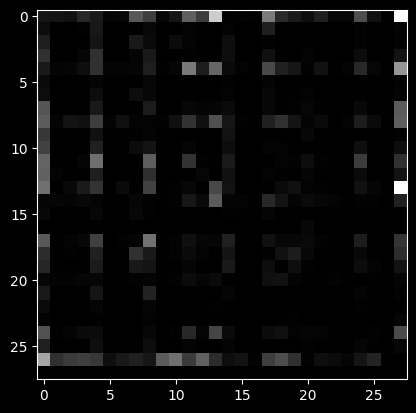

In [55]:
plt.imshow(N, cmap='gray')

In [56]:
itos = {i:s for s, i in stoi.items()}
itos

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'j',
 10: 'k',
 11: 'l',
 12: 'm',
 13: 'n',
 14: 'o',
 15: 'p',
 16: 'q',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'x',
 24: 'y',
 25: 'z',
 26: '<S>',
 27: '<E>'}

In [57]:
stoi

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '<S>': 26,
 '<E>': 27}

### Визуализация частоты встречаемости сочетаний букв

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

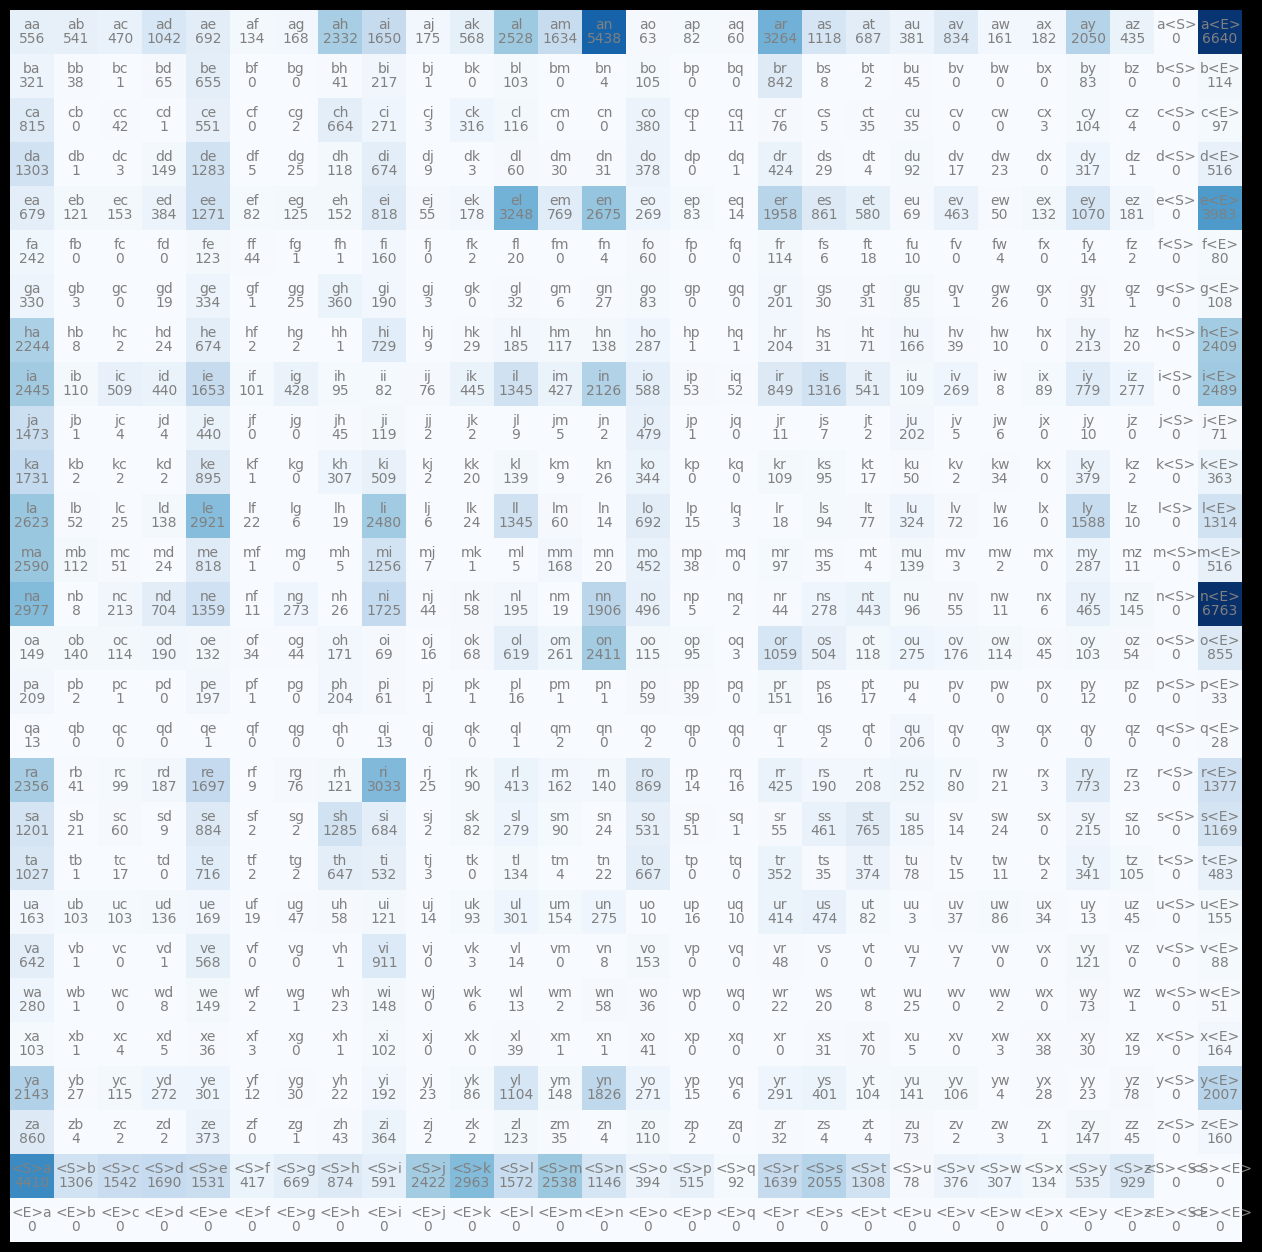

In [58]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')

# Выношу подписи текстом
for i in range(28):
    for j in range(28):
        chstr = itos[i] + itos[j]
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='grey')
        plt.text(j, i, chstr, ha='center', va='bottom', color='grey')
plt.axis('off')

Как доставать значения из tensor

In [59]:
N[3, 3]

tensor(149, dtype=torch.int32)

In [60]:
type(N[3, 3])

torch.Tensor

In [61]:
# Достать элемент из тензора
N[3, 3].item()

149

Надо вычленить пустые строки, после E никогда не будет символа, так же как и перед S

In [62]:
N = torch.zeros(27, 27, dtype=torch.int32)

In [63]:
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [64]:
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [65]:
for w in words:
    chs = ['.'] + list(w)  + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):

        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

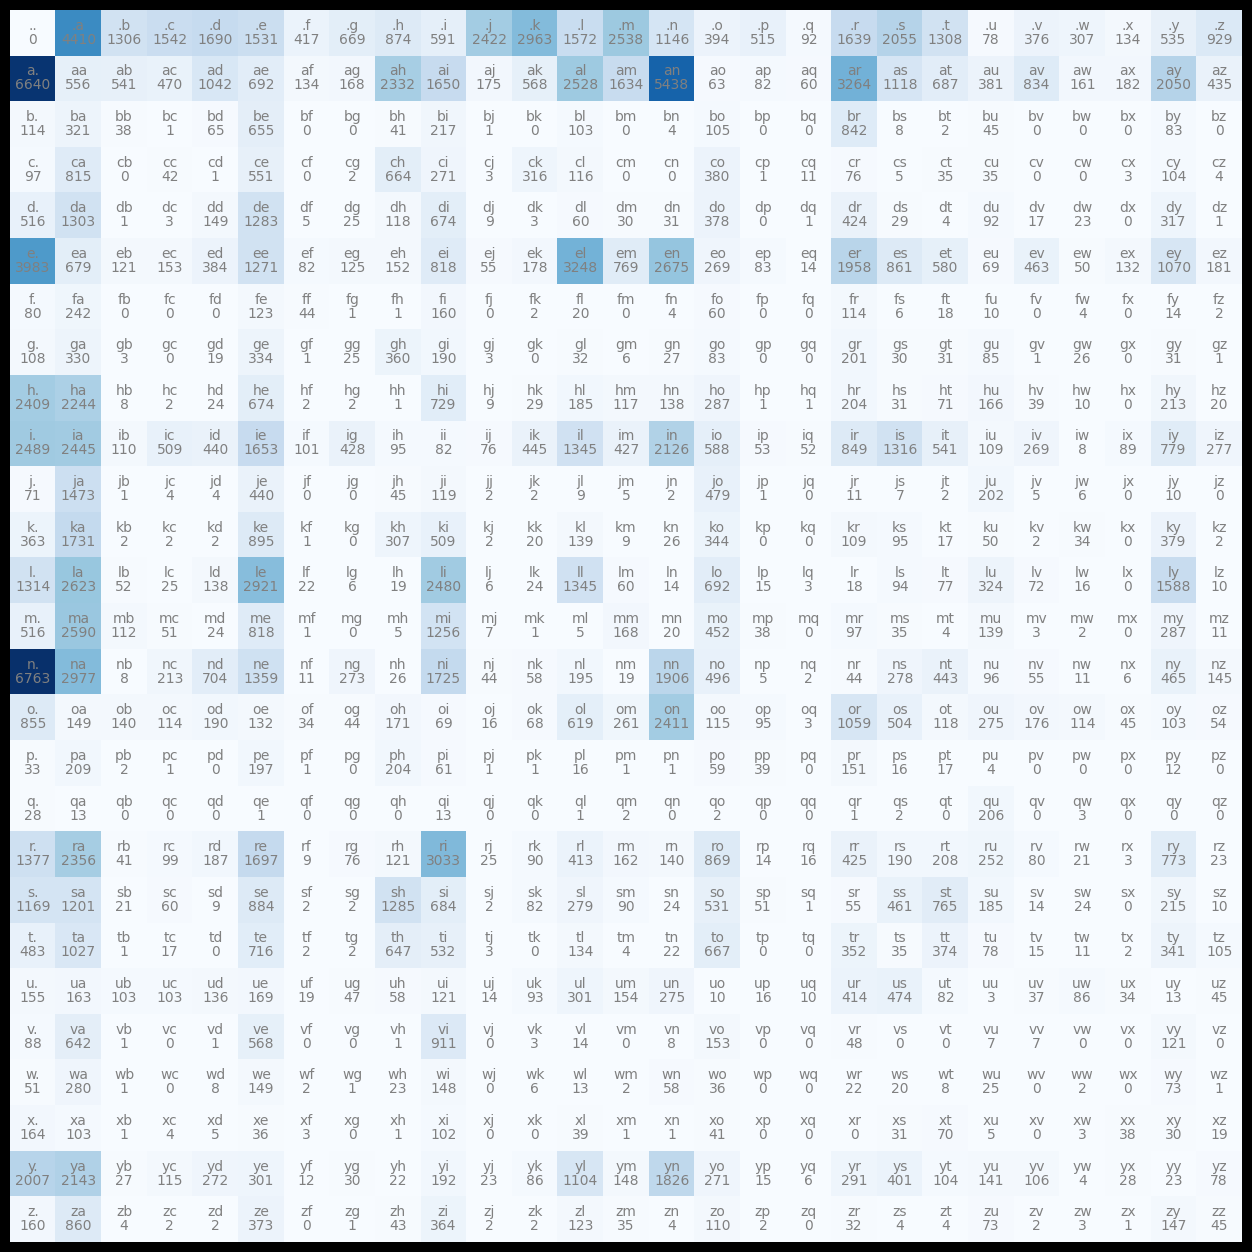

In [66]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')

# Выношу подписи текстом
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='grey')
        plt.text(j, i, chstr, ha='center', va='bottom', color='grey')
plt.axis('off')

### Семплирование токенов

In [67]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

Вероятность каждого символа быть первым в слове

In [68]:
p = N[0].float()
p /= p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [69]:
p.sum()

tensor(1.)

https://docs.pytorch.org/docs/stable/generated/torch.multinomial.html

https://docs.pytorch.org/docs/stable/generated/torch.Generator.html

### Принцип работы генератора и семплера

In [70]:
g = torch.Generator().manual_seed(42)
# Указываем каким генератором пользоваться, тк seed зафиксирован - результат стабилен
p_toy = torch.rand(3, generator=g)
p_toy = p_toy / sum(p_toy)
p_toy

tensor([0.4047, 0.4197, 0.1756])

In [71]:
# torch.multinomial(p, ...) возвращает не сами вероятности, а номера элементов, выбранные согласно этим вероятностям.
torch.multinomial(p_toy, num_samples=20, replacement=True, generator=g)

tensor([1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2])

### Семплирование первой буквы слова

Почему-то если не переопределить генератор, а юзать тот что уже использовался раньше, то будут выдаваться разные индексы

In [72]:
g = torch.Generator().manual_seed(42)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
ix

1

In [73]:
itos[ix]

'a'

### Семплируем более 1 символа

Алгоритм работает, но не очень хорошо, такой уж алгоритм

In [74]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    ix=0
    out = []
    while True:
        p = N[ix].float()
        p /= p.sum()
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.


Для сравнения приводится алгоритм уровня случайный шум, где везде одинаковые шансы встретить любую букву, видно, что все таки bigram чему-то да научился

In [75]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    ix=0
    out = []
    while True:
        p = torch.ones(27) / 27
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

cexzm.
zoglkurkicqzktyhwmvmzimjttainrlkfukzkktda.
sfcxvpubjtbhrmgotzx.
iczixqctvujkwptedogkkjemkmmsidguenkbvgynywftbspmhwcivgbvtahlvsu.
dsdxxblnwglhpyiw.
igwnjwrpfdwipkwzkm.
desu.
firmt.
gbiksjbquabsvoth.
kuysxqevhcmrbxmcwyhrrjenvxmvpfkmwmghfvjzxobomysox.


In [76]:
# Дошел до 36.24

### Vectorizing

https://youtu.be/PaCmpygFfXo?si=Swjph6sX020n5Bc-&t=2178

https://docs.pytorch.org/docs/stable/notes/broadcasting.html

In [77]:
P = N / N.sum(dim=1, keepdim=True)
P.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [78]:
N.sum(dim=1).shape

torch.Size([27])

In [79]:
N.sum(dim=1, keepdim=True).shape

torch.Size([27, 1])

In [80]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    ix=0
    out = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


### Оценка перфоманса модели

log (a * b * c ) = log(a) + log(b) + log(c)

In [81]:
# GOAL: maximize likelihood of the data w.r.f. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log

In [82]:
log_likelihood = 0.0
n=0

for w in words[:3]:
    chs = ['.'] + list(w)  + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1} {ch2}: {prob:.3f} {logprob:.3f}')

log_likelihood /= n
print(log_likelihood)
print(f'{log_likelihood}')
print(f'{log_likelihood=}')

# negative log likelihood function.
nll = -log_likelihood
print(nll)
print(f'{nll}')
print(f'{nll=}')

tensor(-2.4241)
-2.424102306365967
log_likelihood=tensor(-2.4241)
tensor(2.4241)
2.424102306365967
nll=tensor(2.4241)


In [83]:
log_likelihood = 0.0
n=0

for w in ['grigorii']:
    chs = ['.'] + list(w)  + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1} {ch2}: {prob:.3f} {logprob:.3f}')

log_likelihood /= n
print(log_likelihood)
print(f'{log_likelihood}')
print(f'{log_likelihood=}')

# average (потому что выше поделил на n) negative log likelihood function.
nll = -log_likelihood
print(nll)
print(f'{nll}')
print(f'{nll=}')

. g: 0.021 -3.869
g r: 0.104 -2.260
r i: 0.239 -1.432
i g: 0.024 -3.722
g o: 0.043 -3.145
o r: 0.133 -2.014
r i: 0.239 -1.432
i i: 0.005 -5.375
i .: 0.141 -1.962
tensor(-2.8012)
-2.8011794090270996
log_likelihood=tensor(-2.8012)
tensor(2.8012)
2.8011794090270996
nll=tensor(2.8012)


In [84]:
# model smoothing, чтобы убрать inf из ошибок
P = (N + 1).float()
P /= P.sum(dim=1, keepdim=True)
P.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [85]:
P.sum(dim=0)

tensor([3.0023, 5.3111, 0.1847, 0.2300, 0.3840, 3.2304, 0.1100, 0.1341, 1.1715,
        2.7497, 0.1235, 0.3330, 1.1707, 0.4055, 1.2774, 1.3664, 0.1091, 0.0295,
        1.6097, 0.7284, 0.5734, 1.1475, 0.1643, 0.1291, 0.1069, 1.0258, 0.1921])

# PART 2, Тренируем shallowNN

In [86]:
# create the training set of all the bigrams (x, y)

xs, ys = [], []
for w in words[:1]:
    chs = ['.'] + list(w)  + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(f'{ch1} {ch2}')
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [87]:
xs

tensor([ 0,  5, 13, 13,  1])

In [88]:
ys

tensor([ 5, 13, 13,  1,  0])

In [89]:
# one-hot-encoding


x_enc = F.one_hot(xs, num_classes=27).float()
x_enc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [90]:
x_enc.shape

torch.Size([5, 27])

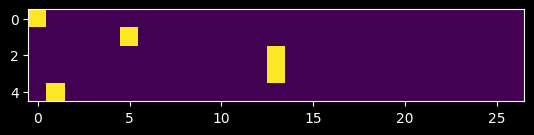

In [91]:
plt.imshow(x_enc)

In [92]:
x_enc.dtype

torch.float32

### Constructing a neuron

27, 1 - 27 входов, один нейрон

Что это означает?

Да, это один нейрон:

	•	27 входов (весов)
	•	1 выход
	•	применён к 5 примерам сразу (батч)

Так что результат — это 5 выходных значений (одно на каждый пример).

✔️ Ваше понимание полностью верно.


In [93]:
W = torch.randn(size=(27, 1))
# 5 x 27 @ 27 x 1 output size 5 x 1
# 5 activations
x_enc @ W

tensor([[-0.1612],
        [-0.2723],
        [-1.7980],
        [-1.7980],
        [ 0.5117]])

27, 27 - 27 входов, 27 нейронов

Что это означает на самом деле?

Это 27 нейронов, и каждый нейрон имеет 27 входов.
И каждый нейрон выдаёт 1 выход, поэтому вместе получается 27 выходов.

x_enc — 5 примеров
→ значит все эти 27 нейронов применяются ко всем 5 примерам.

✔️ В итоге получается:

	•	27 нейронов
	•	27 входов на нейрон
	•	27 выходов
	•	для 5 примеров → итоговая матрица 5 × 27

W тут матрица весов, для весов каждого нейрона своя колонка

In [94]:
W = torch.randn(size=(27, 27))
# 27 x 27 @ 27 x 1 output size 5 x 1
# 5 activations
x_enc @ W

tensor([[ 1.3467, -1.7562, -0.0140, -0.5358, -0.1838, -0.6399, -0.7171,  0.6022,
          0.1597, -0.6447,  2.4303,  0.5971, -1.4452,  0.5826, -0.5154, -0.2101,
         -0.3030, -0.5974, -0.1271,  0.8200, -2.0393, -0.2516,  0.1157, -0.1122,
          1.1533, -1.2016, -1.5762],
        [ 0.3625, -1.2748, -0.7674,  0.8008,  0.1581, -1.0648, -0.7095,  0.5086,
         -0.8036, -0.9499,  0.7302,  0.0071, -0.4666,  0.1167, -2.2234, -0.6678,
          0.9568,  0.9454, -0.4166, -0.0892, -0.3887,  0.2471,  0.9316, -1.0945,
         -0.2743, -2.3801,  0.5048],
        [ 0.0060, -1.0679, -1.0147,  1.2422, -1.0290,  0.3467, -0.1132,  2.3595,
         -1.2673, -1.8229,  0.0602,  1.1664,  0.5039,  1.2524,  0.4838, -0.1660,
          0.4120, -0.5047,  1.3590,  2.7267,  0.6296, -1.0023,  1.1641,  0.1059,
          0.1801,  0.9147, -0.1912],
        [ 0.0060, -1.0679, -1.0147,  1.2422, -1.0290,  0.3467, -0.1132,  2.3595,
         -1.2673, -1.8229,  0.0602,  1.1664,  0.5039,  1.2524,  0.4838, -0.1660

In [95]:
x_enc[3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

Активация 13 нейрона на 3 инпут (буква m)

In [96]:
(x_enc @ W)[3, 13]

tensor(1.2524)

In [97]:
W[:, 13]

tensor([ 0.5826,  0.4990, -0.3837,  0.3375,  0.4649,  0.1167, -0.0430,  1.4461,
         0.9533, -1.2468,  0.4795,  0.2983, -0.4349,  1.2524, -0.0420, -1.1343,
         0.8691,  0.6465, -0.6005,  0.7568, -0.2992, -0.9399,  0.1806, -1.1280,
         0.4027,  0.4029, -0.5977])

Посчитал руками активацию

In [98]:
(x_enc[3] * W[:, 13]).sum()

tensor(1.2524)

In [99]:
logits = x_enc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
probs

tensor([[0.0996, 0.0045, 0.0255, 0.0152, 0.0215, 0.0137, 0.0126, 0.0473, 0.0304,
         0.0136, 0.2943, 0.0470, 0.0061, 0.0464, 0.0155, 0.0210, 0.0191, 0.0142,
         0.0228, 0.0588, 0.0034, 0.0201, 0.0291, 0.0231, 0.0821, 0.0078, 0.0054],
        [0.0505, 0.0098, 0.0163, 0.0783, 0.0412, 0.0121, 0.0173, 0.0584, 0.0157,
         0.0136, 0.0729, 0.0354, 0.0220, 0.0395, 0.0038, 0.0180, 0.0915, 0.0904,
         0.0232, 0.0321, 0.0238, 0.0450, 0.0892, 0.0118, 0.0267, 0.0033, 0.0582],
        [0.0159, 0.0054, 0.0057, 0.0549, 0.0057, 0.0224, 0.0141, 0.1677, 0.0045,
         0.0026, 0.0168, 0.0509, 0.0262, 0.0554, 0.0257, 0.0134, 0.0239, 0.0096,
         0.0617, 0.2421, 0.0297, 0.0058, 0.0507, 0.0176, 0.0190, 0.0395, 0.0131],
        [0.0159, 0.0054, 0.0057, 0.0549, 0.0057, 0.0224, 0.0141, 0.1677, 0.0045,
         0.0026, 0.0168, 0.0509, 0.0262, 0.0554, 0.0257, 0.0134, 0.0239, 0.0096,
         0.0617, 0.2421, 0.0297, 0.0058, 0.0507, 0.0176, 0.0190, 0.0395, 0.0131],
        [0.0366, 0.0135,

In [100]:
probs.sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [101]:
probs

tensor([[0.0996, 0.0045, 0.0255, 0.0152, 0.0215, 0.0137, 0.0126, 0.0473, 0.0304,
         0.0136, 0.2943, 0.0470, 0.0061, 0.0464, 0.0155, 0.0210, 0.0191, 0.0142,
         0.0228, 0.0588, 0.0034, 0.0201, 0.0291, 0.0231, 0.0821, 0.0078, 0.0054],
        [0.0505, 0.0098, 0.0163, 0.0783, 0.0412, 0.0121, 0.0173, 0.0584, 0.0157,
         0.0136, 0.0729, 0.0354, 0.0220, 0.0395, 0.0038, 0.0180, 0.0915, 0.0904,
         0.0232, 0.0321, 0.0238, 0.0450, 0.0892, 0.0118, 0.0267, 0.0033, 0.0582],
        [0.0159, 0.0054, 0.0057, 0.0549, 0.0057, 0.0224, 0.0141, 0.1677, 0.0045,
         0.0026, 0.0168, 0.0509, 0.0262, 0.0554, 0.0257, 0.0134, 0.0239, 0.0096,
         0.0617, 0.2421, 0.0297, 0.0058, 0.0507, 0.0176, 0.0190, 0.0395, 0.0131],
        [0.0159, 0.0054, 0.0057, 0.0549, 0.0057, 0.0224, 0.0141, 0.1677, 0.0045,
         0.0026, 0.0168, 0.0509, 0.0262, 0.0554, 0.0257, 0.0134, 0.0239, 0.0096,
         0.0617, 0.2421, 0.0297, 0.0058, 0.0507, 0.0176, 0.0190, 0.0395, 0.0131],
        [0.0366, 0.0135,

In [102]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(size=(27, 27), generator=g).float()

In [103]:
xs

tensor([ 0,  5, 13, 13,  1])

In [104]:
x_enc = F.one_hot(xs, num_classes=27).float()
x_enc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [105]:
g = torch.Generator().manual_seed(2147483647 + 1)
W = torch.randn(size=(27, 27), generator=g).float()

# Forward pass
x_enc = F.one_hot(xs, num_classes=27).float()
# Logits — это необработанные численные выходы модели (например, нейросети) до применения функции активации, такой как softmax или sigmoid.
logits = x_enc @ W # predict log counts
counts = logits.exp() # counts equivalent to n
probs = counts / counts.sum(1, keepdim=True)
probs.sum(1)

tensor([1., 1., 1., 1., 1.])

Softmax получает вход, и выдает положительные числа суммирующиеся в 1, поэтому он крут для вероятностей

In [106]:
probs.shape

torch.Size([5, 27])

Перфоманс случайно сгенерированных весов

In [107]:
nlls = torch.zeros(5)

for i in range(5):
    x = xs[i].item()
    y = ys[i].item()
    print('---------')
    print(f'Bigram example: {i + 1}: {itos[x]}:{itos[y]}')
    print(f'Input to the NN {x}')

    print(f'Output probabilities of the nn {probs[i]}')
    print(f'Actual label {y}')
    p = probs[i, y]
    print(f'Probability of the correct answer is: {p.item()}')
    logp = torch.log(p)
    nll = -logp
    nlls[i] = nll

---------
Bigram example: 1: .:e
Input to the NN 0
Output probabilities of the nn tensor([0.0049, 0.0959, 0.0281, 0.0703, 0.0961, 0.0573, 0.0241, 0.0135, 0.0093,
        0.1416, 0.0225, 0.0217, 0.0513, 0.0106, 0.0097, 0.0291, 0.0229, 0.0273,
        0.0325, 0.0275, 0.0446, 0.0501, 0.0214, 0.0093, 0.0120, 0.0354, 0.0310])
Actual label 5
Probability of the correct answer is: 0.057345062494277954
---------
Bigram example: 2: e:m
Input to the NN 5
Output probabilities of the nn tensor([0.0426, 0.0113, 0.0266, 0.0507, 0.2370, 0.0580, 0.0421, 0.0094, 0.0136,
        0.0297, 0.0044, 0.0782, 0.1028, 0.0146, 0.0172, 0.0288, 0.0263, 0.0319,
        0.0248, 0.0210, 0.0063, 0.0057, 0.0309, 0.0269, 0.0298, 0.0089, 0.0205])
Actual label 13
Probability of the correct answer is: 0.014588626101613045
---------
Bigram example: 3: m:m
Input to the NN 13
Output probabilities of the nn tensor([0.0973, 0.0235, 0.2014, 0.0240, 0.0510, 0.0341, 0.0644, 0.0075, 0.0197,
        0.0502, 0.0316, 0.0015, 0.0192, 0.

In [108]:
print(f'{nlls.mean().item():.3f}')

3.377


In [109]:
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

### Сбор оптимизируемой нейронки

In [110]:
probs.shape

torch.Size([5, 27])

In [111]:
probs[0, 5], probs[1, 13], probs[2, 13], probs[3, 1], probs[4, 0]

(tensor(0.0573),
 tensor(0.0146),
 tensor(0.0321),
 tensor(0.0235),
 tensor(0.0737))

In [112]:
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [113]:
loss = -probs[torch.arange(5), ys].log().mean()

In [114]:
g = torch.Generator().manual_seed(2147483647 + 1)
W = torch.randn(size=(27, 27), generator=g, requires_grad=True).float()

Forward pass

In [115]:
x_enc = F.one_hot(xs, num_classes=27).float()
# Logits — это необработанные численные выходы модели (например, нейросети) до применения функции активации, такой как softmax или sigmoid.
logits = x_enc @ W # predict log counts
counts = logits.exp() # counts equivalent to n
probs = counts / counts.sum(1, keepdim=True)
loss = -probs[torch.arange(5), ys].log().mean()
loss

tensor(3.3771, grad_fn=<NegBackward0>)

Backward pass

In [116]:
print(W.grad)
W.grad = None # set the gradient to 0
# При вызове backward вычисляются градиенты и записываются в W.grad
loss.backward()

# Обновляем веса через -0.1 * grad
# Минус потому что градиенты показывают в сторону увеличения функции ошибки, поэтому домножать надо на минус них
W.data += -0.1 * W.grad

None


In [117]:
print(loss.item())

3.3770878314971924


In [118]:
print(loss.item())

3.3770878314971924


In [119]:
print(loss.item())

3.3770878314971924


### Сам загоняю в цикл для оптимизации и визуализации

In [120]:
# create the training set of all the bigrams (x, y)

xs, ys = [], []
for w in words:
    chs = ['.'] + list(w)  + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        # print(f'{ch1} {ch2}')
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples:', len(xs))
print('number of examples:', num)


number of examples: 228146
number of examples: 228146


In [121]:
def train_shallow_nn(n_iters, lr, reg=None):
    errors = []

    g = torch.Generator().manual_seed(2147483647 + 1)
    W = torch.randn(size=(27, 27), generator=g, requires_grad=True).float()

    for i in tqdm(range(n_iters)):
        # Forward pass
        x_enc = F.one_hot(xs, num_classes=27).float()
        # Logits — это необработанные численные выходы модели (например, нейросети) до применения функции активации, такой как softmax или sigmoid.
        logits = x_enc @ W # predict log counts
        counts = logits.exp() # counts equivalent to n
        probs = counts / counts.sum(1, keepdim=True)

        if reg:
            loss = -probs[torch.arange(num), ys].log().mean() + reg * (W**2).mean()
        else:
            loss = -probs[torch.arange(num), ys].log().mean()

        W.grad = None # set the gradient to 0
        # При вызове backw
        loss.backward()

        # Обновляем веса через -0.1 * grad
        # Минус потому что градиенты показывают в сторону увеличения функции ошибки, поэтому домножать надо на минус них
        W.data += -lr * W.grad

        errors.append(loss.item())

    plot_data = {
        i:e for i, e in enumerate(errors)
    }
    print(f'Last error: {plot_data[n_iters - 1]}')
    plt.plot(plot_data.keys(), plot_data.values())

100%|██████████| 100/100 [00:02<00:00, 36.46it/s]


Last error: 3.6833372116088867


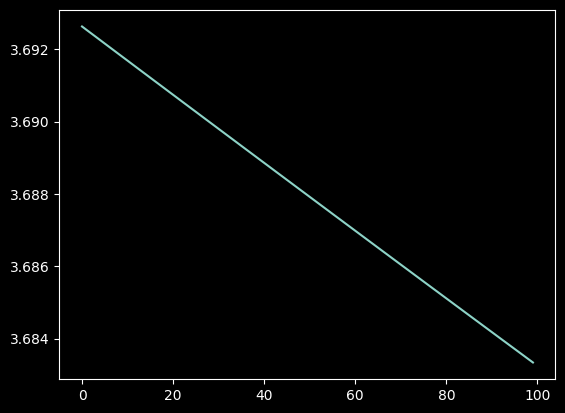

In [122]:
train_shallow_nn(n_iters=100,
                 lr=0.01)

100%|██████████| 100/100 [00:02<00:00, 37.24it/s]


Last error: 3.605952739715576


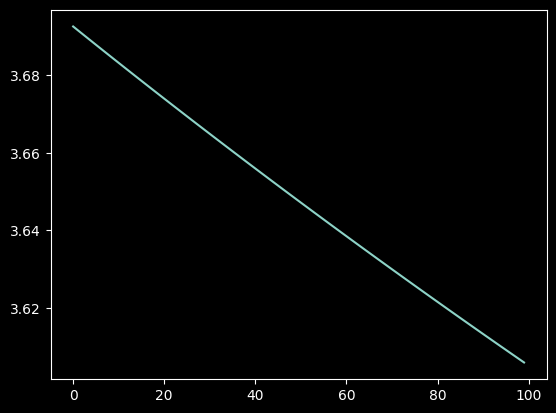

In [123]:
train_shallow_nn(n_iters=100,
                 lr=0.1)

100%|██████████| 100/100 [00:02<00:00, 38.20it/s]


Last error: 3.1497445106506348


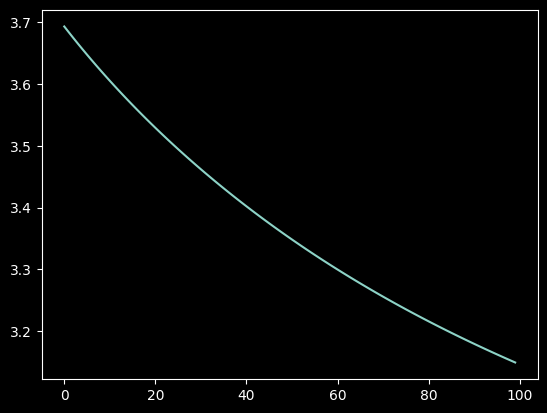

In [124]:
train_shallow_nn(n_iters=100,
                 lr=1)

100%|██████████| 100/100 [00:02<00:00, 38.74it/s]


Last error: 2.5727040767669678


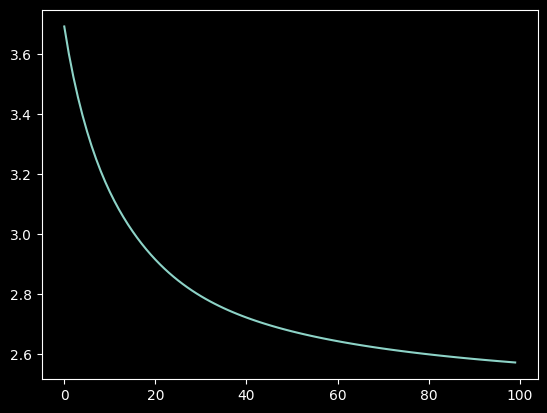

In [125]:
train_shallow_nn(n_iters=100,
                 lr=10)

100%|██████████| 100/100 [00:02<00:00, 43.01it/s]

Last error: 2.5829222202301025


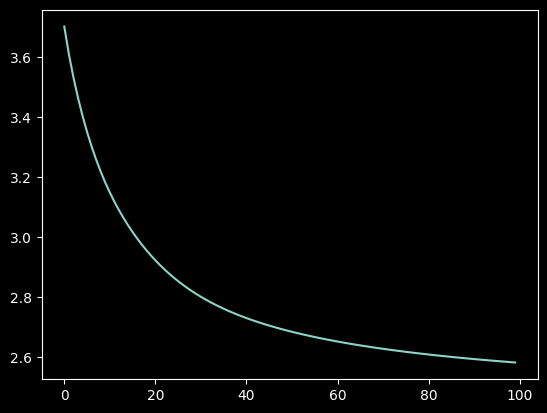

In [126]:
train_shallow_nn(n_iters=100,
                 lr=10,
                 reg=0.01)

### Семплирование из NN

Случайный перфоманс

In [127]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(size=(27, 27), generator=g, requires_grad=True).float()

In [128]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    ix=0
    out = []
    while True:
        x_enc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = x_enc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdim=True)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

zexzmkloglquszipczktxhkmpmzisttt.
inmlufbkzkkt.
g.
zwmxtpucjwtsc.
gmtokmxczislwtxugkwpt.
dajkkluydjmszdgu.
nkavgdngqfolspxhucjvgbvtrhtvsuzwsdcxblnwglhpygw.
isz.
p.
opfdwchkfbwmkdusz.


In [129]:
n_iters = 1000
reg = 0.01
lr = 10

In [130]:
errors = []

g = torch.Generator().manual_seed(2147483647)
W = torch.randn(size=(27, 27), generator=g, requires_grad=True).float()

for i in tqdm(range(n_iters)):
    # Forward pass
    x_enc = F.one_hot(xs, num_classes=27).float()
    # Logits — это необработанные численные выходы модели (например, нейросети) до применения функции активации, такой как softmax или sigmoid.
    logits = x_enc @ W # predict log counts
    counts = logits.exp() # counts equivalent to n
    probs = counts / counts.sum(1, keepdim=True)

    if reg:
        loss = -probs[torch.arange(num), ys].log().mean() + reg * (W**2).mean()
    else:
        loss = -probs[torch.arange(num), ys].log().mean()

    W.grad = None # set the gradient to 0
    # При вызове backw
    loss.backward()

    # Обновляем веса через -0.1 * grad
    # Минус потому что градиенты показывают в сторону увеличения функции ошибки, поэтому домножать надо на минус них
    W.data += -lr * W.grad

100%|██████████| 1000/1000 [00:23<00:00, 42.04it/s]


Семплирование после дообучения

In [131]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    ix=0
    out = []
    while True:
        x_enc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = x_enc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdim=True)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.


Семплирование через bigram

In [132]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    ix=0
    out = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
